In [272]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt


import warnings
from warnings import filterwarnings

from sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.exceptions import DataConversionWarning


In [273]:
# Load the dataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from DataPreparation.Ingestion.Ingestion import read_data, visualize_data

from DataPreparation.Preprocessing.Preprocessing import preprocess_data

data = read_data(
    path='./DataFiles/house-prices-advanced-regression-techniques')

# x_train_p, y_train, x_val_p, y_val = preprocess_data(data)


In [274]:
from scipy.stats import chi2_contingency
independents = ["Fireplaces", "FireplaceQu", "Heating", "CentralAir"]
dependent = ["HeatingQC"]

data = data[independents + dependent]
# Check for null values
data.isnull().sum()

# Fill null values
data["FireplaceQu"] = data["FireplaceQu"].fillna("None")

threshold = 0.05

# For every pair of features, run Chi-Square test
for i in range(len(independents)):
        cont_table = pd.crosstab(data[independents[i]], data[dependent[0]])
        chi2, pval, dof, expected = chi2_contingency(cont_table)
        if pval <= threshold:
            print("Chi-Square test between",
                  independents[i], "and", dependent[0], ":correlated")
        else:
            print("Chi-Square test between",
                  independents[i], "and", dependent[0], ":not correlated")


Chi-Square test between Fireplaces and HeatingQC :correlated
Chi-Square test between FireplaceQu and HeatingQC :correlated
Chi-Square test between Heating and HeatingQC :correlated
Chi-Square test between CentralAir and HeatingQC :correlated


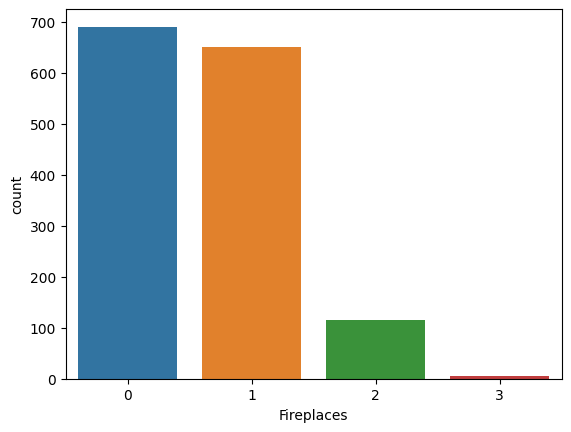

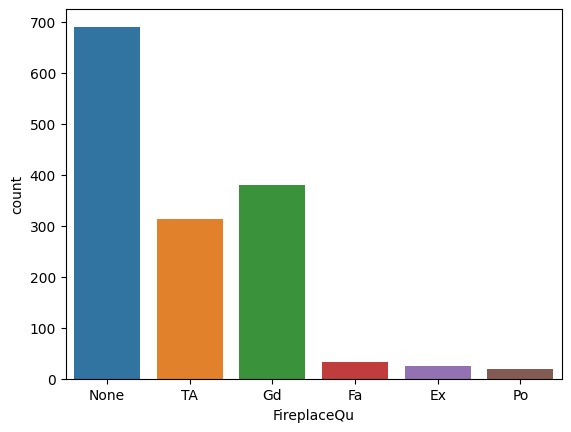

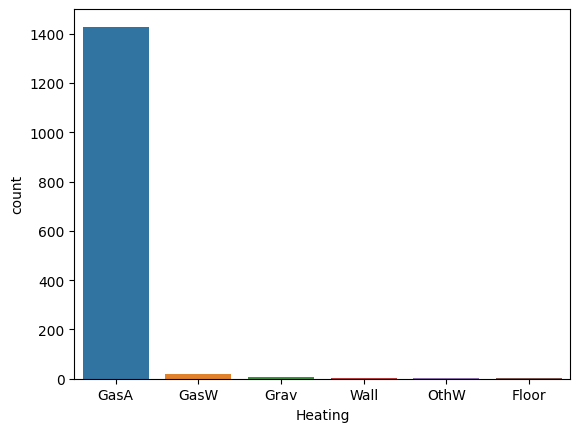

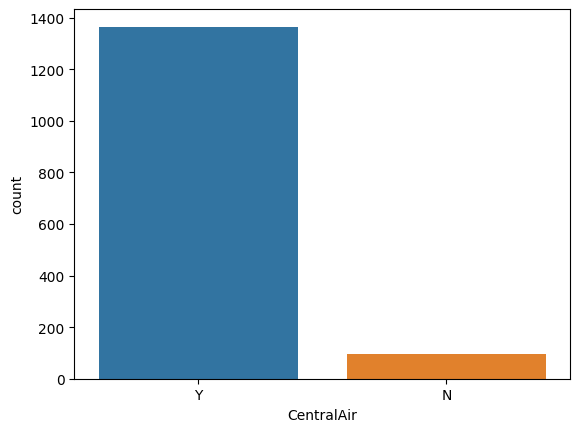

In [275]:
# Plot Histogram for each independent feature
for i in range(len(independents)):
    plt.figure(i)
    sns.countplot(x=independents[i], data=data)
    plt.show()

Heating  HeatingQC
Floor    TA             1
GasA     Ex           739
         Fa            34
         Gd           239
         Po             1
         TA           415
GasW     Ex             2
         Fa             3
         Gd             2
         TA            11
Grav     Fa             7
OthW     Fa             2
Wall     Fa             3
         TA             1
dtype: int64


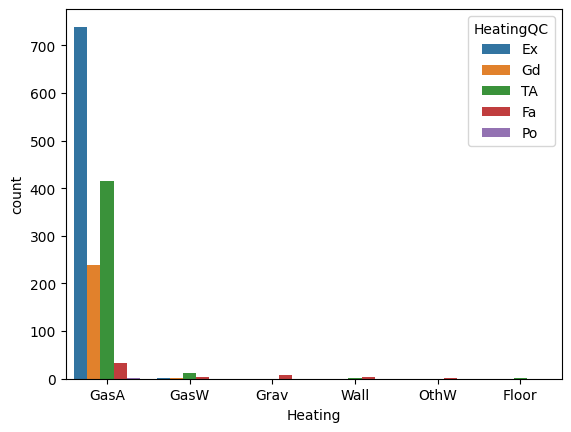

In [276]:
# Print HeatingQC vs Heating
print(data.groupby(["Heating", "HeatingQC"]).size())


# Plot relation between Heating and HeatingQC
plt.figure(0)
sns.countplot(x="Heating", hue="HeatingQC", data=data)
plt.show()

In [277]:
# Print unique values of each column in data
for col in data.columns:
    print(col, ":", data[col].unique())

# Convert categorical data to numerical data
data["FireplaceQu"] = data["FireplaceQu"].map(
    {"None": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5})

data["CentralAir"] = data["CentralAir"].map({"N": 0, "Y": 1})

data["HeatingQC"] = data["HeatingQC"].map(
    {"Po": 0, "Fa": 1, "TA": 2, "Gd": 3, "Ex": 4})

# Print unique values of each column in data
for col in data.columns:
    print(col, ":", data[col].unique())

Fireplaces : [0 1 2 3]
FireplaceQu : ['None' 'TA' 'Gd' 'Fa' 'Ex' 'Po']
Heating : ['GasA' 'GasW' 'Grav' 'Wall' 'OthW' 'Floor']
CentralAir : ['Y' 'N']
HeatingQC : ['Ex' 'Gd' 'TA' 'Fa' 'Po']
Fireplaces : [0 1 2 3]
FireplaceQu : [0 3 4 2 5 1]
Heating : ['GasA' 'GasW' 'Grav' 'Wall' 'OthW' 'Floor']
CentralAir : [1 0]
HeatingQC : [4 3 2 1 0]


In [278]:
# Get mean of HeatingQC for FireplacesQu <= 2
mean = data[data["FireplaceQu"] <= 2]["HeatingQC"].mean()
print("Mean of HeatingQC for FireplacesQu <= 2:", mean)

# Get mean of HeatingQC for FireplacesQu > 2
mean = data[data["FireplaceQu"] > 2]["HeatingQC"].mean()
print("Mean of HeatingQC for FireplacesQu > 2:", mean)

Mean of HeatingQC for FireplacesQu <= 2: 2.9609690444145356
Mean of HeatingQC for FireplacesQu > 2: 3.336122733612273


In [279]:
# Study effect of increasing FireplaceQu on HeatingQC
focused_data = data[["FireplaceQu", "HeatingQC"]]
# Get split dataframe base on FireplaceQ values
control = focused_data[focused_data["FireplaceQu"] <= 2]
treatment = focused_data[focused_data["FireplaceQu"] > 2]

# Get treatment size
treatment_size = len(treatment)
# Get control size
control_size = len(control)

print("Treatment size:", treatment_size)
print("Control size:", control_size)

Treatment size: 717
Control size: 743


In [280]:
# data before the treatment
df_before = control
df_before['t'] = 0
df_before.columns = ['Heating', 'g', 't']

# data after the treatment
df_after = treatment
df_after['t'] = 1
df_after.columns = ['Heating', 'g', 't']

# Concatenate the dataframes
df_reg = pd.concat([df_before, df_after])

# create the interaction
df_reg['gt'] = df_reg.g * df_reg.t

df_reg

/tmp/ipykernel_4179/336142182.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_before['t'] = 0
/tmp/ipykernel_4179/336142182.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_after['t'] = 1


,Heating,g,t,gt
0,0,4,0,0
5,0,4,0,0
10,0,4,0,0
12,0,2,0,0
14,2,2,0,0
...,...,...,...,...
1447,3,4,1,4
1451,4,4,1,4
1455,3,4,1,4
1456,3,2,1,2


In [281]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

X = df_reg[['g', 't', 'gt']]
y = df_reg.Heating

lr.fit(X, y)
lr.coef_  # the coefficient for gt is the DID, which is 0.11770643


array([-0.01507837,  3.09415831,  0.11770643])

In [282]:
from statsmodels.formula.api import ols
ols = ols('Heating ~ g + t + gt', data=df_reg).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                Heating   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                     6033.
Date:                Mon, 15 May 2023   Prob (F-statistic):               0.00
Time:                        20:18:40   Log-Likelihood:                -1041.9
No. Observations:                1460   AIC:                             2092.
Df Residuals:                    1456   BIC:                             2113.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1604      0.058      2.764      0.0

In [283]:
import scipy.stats
α = 0.05  # significance level

#find T critical value for right-tailed test
scipy.stats.t.ppf(1-α,1456)

1.645900841941544

In [284]:
# Get mean of HeatingQC for Fireplaces <= 1
mean = data[data["Fireplaces"] <= 1]["HeatingQC"].mean()
print("Mean of HeatingQC for Fireplaces <= 1:", mean)

# Get mean of HeatingQC for Fireplaces > 1
mean = data[data["Fireplaces"] > 1]["HeatingQC"].mean()
print("Mean of HeatingQC for Fireplaces > 1:", mean)

Mean of HeatingQC for Fireplaces <= 1: 3.1470149253731345
Mean of HeatingQC for Fireplaces > 1: 3.125


In [285]:
# Study effect of increasing Fireplaces on HeatingQC

focused_data = data[["Fireplaces", "HeatingQC"]]
# Get split dataframe base on FireplaceQ values
control = focused_data[focused_data["Fireplaces"] <= 1]
treatment = focused_data[focused_data["Fireplaces"] > 1]

# Get treatment size
treatment_size = len(treatment)
# Get control size
control_size = len(control)

print("Treatment size:", treatment_size)
print("Control size:", control_size)

Treatment size: 120
Control size: 1340


In [286]:
# data before the treatment
df_before = control
df_before['t'] = 0
df_before.columns = ['Heating', 'g', 't']

# data after the treatment
df_after = treatment
df_after['t'] = 1
df_after.columns = ['Heating', 'g', 't']

# Concatenate the dataframes
df_reg = pd.concat([df_before, df_after])

# create the interaction
df_reg['gt'] = df_reg.g * df_reg.t

df_reg

/tmp/ipykernel_4179/336142182.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_before['t'] = 0
/tmp/ipykernel_4179/336142182.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_after['t'] = 1


,Heating,g,t,gt
0,0,4,0,0
1,1,4,0,0
2,1,4,0,0
3,1,3,0,0
4,1,4,0,0
...,...,...,...,...
1396,2,2,1,2
1426,2,4,1,4
1428,2,2,1,2
1456,2,2,1,2


In [287]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

X = df_reg[['g', 't', 'gt']]
y = df_reg.Heating

lr.fit(X, y)
lr.coef_  # the coefficient for gt is the DID, which is -0.08568014

array([ 0.09741973,  1.82648716, -0.08568014])

In [288]:
from statsmodels.formula.api import ols
ols = ols('Heating ~ g + t + gt', data=df_reg).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:                Heating   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.458
Method:                 Least Squares   F-statistic:                     412.3
Date:                Mon, 15 May 2023   Prob (F-statistic):          7.84e-194
Time:                        20:18:40   Log-Likelihood:                -981.28
No. Observations:                1460   AIC:                             1971.
Df Residuals:                    1456   BIC:                             1992.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1785      0.045      4.004      0.0

In [293]:
import scipy.stats
α = 0.05  # significance level

#find T critical value for left-tailed test
scipy.stats.t.ppf(α,1456)

-1.6459008419415446

In [290]:
# Get mean of HeatingQC for CentralAir = 0
mean = data[data["CentralAir"] == 0]["HeatingQC"].mean()
print("Mean of HeatingQC for CentralAir = 0:", mean)

# Get mean of HeatingQC for CentralAir = 1
mean = data[data["CentralAir"] == 1]["HeatingQC"].mean()
print("Mean of HeatingQC for CentralAir = 1:", mean)

Mean of HeatingQC for CentralAir = 0: 2.031578947368421
Mean of HeatingQC for CentralAir = 1: 3.222710622710623


In [291]:
# Study effect of increasing CentralAir on HeatingQC

focused_data = data[["CentralAir", "HeatingQC"]]
# Get split dataframe base on CentralAir values
control = focused_data[focused_data["CentralAir"] == 0]
treatment = focused_data[focused_data["CentralAir"] == 1]

# Get treatment size
treatment_size = len(treatment)
# Get control size
control_size = len(control)

print("Treatment size:", treatment_size)
print("Control size:", control_size)


Treatment size: 1365
Control size: 95


In [292]:
# data before the treatment
df_before = control
df_before['t'] = 0
df_before.columns = ['Heating', 'g', 't']

# data after the treatment
df_after = treatment
df_after['t'] = 1
df_after.columns = ['Heating', 'g', 't']



/tmp/ipykernel_4179/1796880792.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_before['t'] = 0
/tmp/ipykernel_4179/1796880792.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_after['t'] = 1
